In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation.mice as smi

In [2]:
file_path = 'pre_imputed_CA_data.csv'
df = pd.read_csv(file_path, #index_col='time',
                    dtype={'BANC':np.float64,
                          'CISO':np.float64,
                          'LDWP':np.float64,
                          'TIDC':np.float64},
                    parse_dates=True, na_values=['NA',])
df.head(10)

,date_time,BANC,CISO,LDWP,TIDC
0,2015-07-01T05:00:00Z,NaN,NaN,NaN,NaN
1,2015-07-01T06:00:00Z,NaN,NaN,NaN,NaN
2,2015-07-01T07:00:00Z,NaN,NaN,NaN,NaN
3,2015-07-01T08:00:00Z,NaN,NaN,NaN,NaN
4,2015-07-01T09:00:00Z,2275.0,28989.0,3045.0,380.0
5,2015-07-01T10:00:00Z,2104.0,27416.0,2892.0,357.0
6,2015-07-01T11:00:00Z,1988.0,26388.0,2787.0,342.0
7,2015-07-01T12:00:00Z,1958.0,25661.0,2790.0,NaN
8,2015-07-01T13:00:00Z,2006.0,25845.0,2899.0,347.0
9,2015-07-01T14:00:00Z,2076.0,26555.0,3097.0,356.0


In [3]:
regions = ['BANC', 'CISO', 'LDWP', 'TIDC']
for r in regions:
    print(r)
    kwargs = {
              '{}_Lag1'.format(r) : lambda x: np.roll(df[r], +1),
             }
    df = df.assign(**kwargs)

# Drop date_time
df = df.drop('date_time', axis=1)

print(df.head(10))

BANC
CISO
LDWP
TIDC
     BANC     CISO    LDWP   TIDC  BANC_Lag1  CISO_Lag1  LDWP_Lag1  TIDC_Lag1
0     NaN      NaN     NaN    NaN     2982.0    28469.0     3264.0      492.0
1     NaN      NaN     NaN    NaN        NaN        NaN        NaN        NaN
2     NaN      NaN     NaN    NaN        NaN        NaN        NaN        NaN
3     NaN      NaN     NaN    NaN        NaN        NaN        NaN        NaN
4  2275.0  28989.0  3045.0  380.0        NaN        NaN        NaN        NaN
5  2104.0  27416.0  2892.0  357.0     2275.0    28989.0     3045.0      380.0
6  1988.0  26388.0  2787.0  342.0     2104.0    27416.0     2892.0      357.0
7  1958.0  25661.0  2790.0    NaN     1988.0    26388.0     2787.0      342.0
8  2006.0  25845.0  2899.0  347.0     1958.0    25661.0     2790.0        NaN
9  2076.0  26555.0  3097.0  356.0     2006.0    25845.0     2899.0      347.0


In [4]:
df.describe().round(2)

,BANC,CISO,LDWP,TIDC,BANC_Lag1,CISO_Lag1,LDWP_Lag1,TIDC_Lag1
count,33909.00,34530.00,34175.00,30772.00,33909.00,34530.00,34175.00,30772.00
mean,1998.16,25947.59,3244.03,298.94,1998.16,25947.59,3244.03,298.94
std,512.90,5066.33,752.67,77.42,512.90,5066.33,752.67,77.42
min,1260.00,14663.00,2019.00,184.00,1260.00,14663.00,2019.00,184.00
25%,1675.00,22253.00,2699.00,248.00,1675.00,22253.00,2699.00,248.00
50%,1885.00,25154.00,3127.00,279.00,1885.00,25154.00,3127.00,279.00
75%,2111.00,28070.75,3532.00,320.00,2111.00,28070.75,3532.00,320.00
max,4763.00,49899.00,7095.00,653.00,4763.00,49899.00,7095.00,653.00


In [5]:
df.isna().sum(axis=0)

BANC         1004
CISO          383
LDWP          738
TIDC         4141
BANC_Lag1    1004
CISO_Lag1     383
LDWP_Lag1     738
TIDC_Lag1    4141
dtype: int64

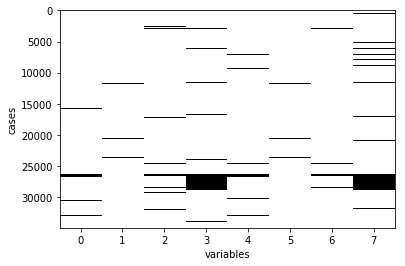

In [6]:
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

In [7]:
# Impute and save the imputed datasets
# Not sure what the burn in is for these
imp = smi.MICEData(df)
imp.set_imputer('CISO', formula='CISO_Lag1 + TIDC + TIDC_Lag1 + LDWP + LDWP_Lag1 + BANC + BANC_Lag1')
for j in range(3):
    imp.update_all()
    imp.data.to_csv('data%02d.csv' % j)

/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:1081: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ix = dxi[[jj, ir]]
/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:1082: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  iz = ixm[[jj, ix]]


In [10]:
## Open a saved csv and check contents

n = pd.read_csv('data00.csv')
#print(n.head())
#print(n.isna().sum(axis=0))
#n.describe().round(2)


def return_only_imputed_vals(raw, imp, name):
    index = pd.isnull(df[name]).nonzero()[0]
    return index

index = return_only_imputed_vals(df, n, 'CISO')
print(df.isna().sum(axis=0))
print(len(index))
#for i, v in zip(index, vals):
#    print(i, v)


#r, x = np.where(df['CISO'].isna())
#print(r), print(x)

#np.where(np.asanyarray(np.isnan(df)))

BANC         1004
CISO          383
LDWP          738
TIDC         4141
BANC_Lag1    1004
CISO_Lag1     383
LDWP_Lag1     738
TIDC_Lag1    4141
dtype: int64
383


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
for r in regions:
    print(r)
    plt.clf()
    fig, ax = plt.subplots(figsize=(40,5))
    ax.plot(n[r], 'b.', label='imp')
    ax.plot(df[r], 'r.', label='raw')
    plt.legend()
    plt.savefig('demand_{}.eps'.format(r))

In [56]:
import copy

def scan_for_missing_structure(df):
    rec = {}
    for col in df.columns:
        if 'Lag1' in col: continue
        rec[col] = [0, []] # missing tally, and record
    for index, row in df.iterrows():
        for col, info in rec.items():
            if np.isnan(row[col]): # incriment missing tally
                info[0] += 1
            elif not np.isnan(row[col]) and info[0] > 0:
                info[1].append(info[0])
                info[0] = 0
    #for k, v in rec.items():
    #    print(k, v)
    return rec

def group_results(groupings, results):
    cats = {}
    for g in groupings:
        cats[g] = 0
    res = {}
    for col, info in results.items():
        res[col] = copy.deepcopy(cats)
        for v in info[1]:
            if v == 1: res[col]['1'] += 1
            elif v <= 5: res[col]['2-5'] += 1
            elif v <= 23: res[col]['5-23'] += 1
            elif v <= 168: res[col]['24-168'] += 1
            elif v <= 1000: res[col]['169-1000'] += 1
            elif v <= 2000: res[col]['1001-2000'] += 1
            elif v <= 3000: res[col]['2001-3000'] += 1
            else: res[col]['3001+'] += 1
    for k, v in res.items():
        print(k, v)
    return res

# Loop over vals in the dataframe and find a continous region which is
# 2x the length of the requested data to remove.
# Change the valse to np.nan and return vals
def remove_locations(df, requested_gaps):
    # Begin with the longest requested gaps and work you way
    # to smaller requested gaps
    for col, info in requested_gaps.items():
        info[1].sort()
        info[1].reverse()
        #print(col, info[1])
        for length in info[1]:
            find_and_remove_location(df, col, length)

def find_and_remove_location(df, col, length):
    # Start at a random index position to not bias the removals
    # all towards the front
    loc = int(np.random.uniform(0, len(df.index)))
    start_of_good_data = loc
    length_of_good_data = 0
    n_loops = 0
    while True:
        if np.isnan(df.at[loc, col]):
            start_of_good_data = loc + 1 # This is the following value
            # and will continuously incriment if isnan()
            length_of_good_data = 0
        else: # good data
            length_of_good_data += 1

        if length_of_good_data == length * 3 - 1:
            print("Found a great stop for removal, col {:}, l={:d}, [{:d}:{:d}]".format(
                    col, length, start_of_good_data, start_of_good_data+length_of_good_data))
            strt = start_of_good_data + length
            end = start_of_good_data + length * 2 - 1
            print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            df.loc[strt:end, col] = np.nan
            print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            return 0
        loc += 1
        
        # Wrap to start of df
        if loc > len(df.index):
            loc = 0
            n_loops += 1
            if n_loops > 1:
                print("Too many loops for col {} and requested length {}".format(col, length))
                return 0

np.random.seed(1)
#results = scan_for_missing_structure(df)
groupings = ['1', '2-5', '5-23',  '24-168', '169-1000', '1001-2000',
            '2001-3000', '3001+']
#results2 = group_results(groupings, results)
df2 = copy.deepcopy(df)
results2 = copy.deepcopy(results)
remove_locations(df2, results2)
print(results)

Found a great stop for removal, col BANC, l=265, [19113:19907]
19113    2101.0
19114    2123.0
19115    2274.0
19116    2512.0
19117    2795.0
19118    3096.0
19119    3374.0
19120    3480.0
19121    3442.0
19122    3463.0
19123    3396.0
19124    3289.0
19125    3164.0
19126    3132.0
19127    3054.0
19128    2870.0
19129    2602.0
19130    2343.0
19131    2160.0
19132    2034.0
19133    1960.0
19134    1921.0
19135    1938.0
19136    2054.0
19137    2228.0
19138    2344.0
19139    2461.0
19140    2614.0
19141    2891.0
19142    3032.0
          ...  
19878    1464.0
19879    1492.0
19880    1591.0
19881    1754.0
19882    1815.0
19883    1855.0
19884    1889.0
19885    1929.0
19886    1976.0
19887    2012.0
19888    2058.0
19889    2127.0
19890    2184.0
19891    2249.0
19892    2256.0
19893    2194.0
19894    2205.0
19895    2112.0
19896    2012.0
19897    1861.0
19898    1716.0
19899    1598.0
19900    1524.0
19901    1469.0
19902    1444.0
19903    1446.0
19904    1477.0
19905    

Name: BANC, dtype: float64
19300    2165.0
19301       NaN
19302    1963.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [29397:29399]
29397    2089.0
29398    2091.0
29399    2031.0
Name: BANC, dtype: float64
29397    2089.0
29398       NaN
29399    2031.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [4335:4337]
4335    2110.0
4336    2087.0
4337    2034.0
Name: BANC, dtype: float64
4335    2110.0
4336       NaN
4337    2034.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [9747:9749]
9747    1965.0
9748    1825.0
9749    1723.0
Name: BANC, dtype: float64
9747    1965.0
9748       NaN
9749    1723.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [20450:20452]
20450    1570.0
20451    1468.0
20452    1408.0
Name: BANC, dtype: float64
20450    1570.0
20451       NaN
20452    1408.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [33853:33855]
33853    

Name: BANC, dtype: float64
21928    1779.0
21929       NaN
21930       NaN
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [9970:9972]
9970    2025.0
9971    2118.0
9972    2235.0
Name: BANC, dtype: float64
9970    2025.0
9971       NaN
9972    2235.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [20488:20490]
20488    1845.0
20489    1851.0
20490    1873.0
Name: BANC, dtype: float64
20488    1845.0
20489       NaN
20490    1873.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [26185:26187]
26185    2266.0
26186    1981.0
26187    1818.0
Name: BANC, dtype: float64
26185    2266.0
26186       NaN
26187    1818.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [29966:29968]
29966    1876.0
29967    1840.0
29968    1829.0
Name: BANC, dtype: float64
29966    1876.0
29967       NaN
29968    1829.0
Name: BANC, dtype: float64
Found a great stop for removal, col BANC, l=1, [26552:26554]
2

KeyError: 34913